In [31]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
%watermark

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
Last updated: 2024-07-17T16:00:08.076714-04:00

Python implementation: CPython
Python version       : 3.12.2
IPython version      : 8.22.2

Compiler    : MSC v.1937 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 167 Stepping 1, GenuineIntel
CPU cores   : 16
Architecture: 64bit



In [32]:
# Libraries 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats
import statsmodels.api as sm

import os
import warnings
import random

custom_params = {"axes.spines.right": False, "axes.spines.top": False}
sns.set_theme(style="ticks", rc=custom_params)

# Customize the font and title size
custom_params = {
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "font.family": "Arial"
}
sns.set_context("notebook", rc=custom_params)

# Set a color palette
sns.set_palette("Set2") 

# Set global option to display numbers in plain format
pd.set_option('display.float_format', '{:.2f}'.format)

warnings.filterwarnings('ignore')
random.seed(1234)

In [33]:
## Auxiliary Functions

def detect_outliers(data, column):
    # Calculate Q1 and Q3
    Q1 = np.percentile(data[column], 25)
    Q3 = np.percentile(data[column], 75)

    # Calculate IQR
    IQR = Q3 - Q1

    # Define the outliers bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data['Outlier'] = data[column].apply(lambda x: 'YES' if x < lower_bound or x > upper_bound else 'NO')

    return data

    
    # Use NumPy to create a boolean array indicating outliers
    #is_outlier = (data[column] < lower_bound) | (data[column] > upper_bound)
    # Convert the boolean array to 'YES'/'NO'
    #data['Outlier'] = np.where(is_outlier, 'YES', 'NO')
    #return data


def proportion_calc(data, column):
    tmp = data[column].value_counts().reset_index(name = 'count')
    tmp['prop'] = tmp['count']/tmp['count'].sum()*100
    return tmp

def test_means_equality(df, data_col, group_col, alpha=0.05):
    # Group the data by the group column
    groups = df[group_col].unique()
    if len(groups) != 2:
        raise ValueError("This function requires exactly 2 groups.")
    
    group1 = df[df[group_col] == groups[0]][data_col].values
    group2 = df[df[group_col] == groups[1]][data_col].values
    
    # Perform Shapiro-Wilk test for normality for each group
    normal1 = stats.shapiro(group1)[1] > alpha
    normal2 = stats.shapiro(group2)[1] > alpha
    
    # Perform Levene's test for equal variances
    equal_var = stats.levene(group1, group2)[1] > alpha
    
    if normal1 and normal2:
        # Use t-test for independent samples
        t_val, p_val = stats.ttest_ind(group1, group2, equal_var=equal_var)
    else:
        # Use Mann-Whitney U test as a non-parametric alternative
        u_val, p_val = stats.mannwhitneyu(group1, group2)
    
     # Determine the result message
    if p_val < alpha:
        message = "There is a statistically significant difference between the groups."
    else:
        message = "There is no statistically significant difference between the groups."


    result = {
        "p-value": p_val,
        "statistically_significant": p_val < alpha,
        "message": message
    }
    
    return result

In [34]:
# Data 

CustomerData = pd.read_excel('DATA/CustomersData.xlsx')
Discount_Coupon = pd.read_csv('DATA/Discount_Coupon.csv')
Marketing_Spend = pd.read_csv('DATA/Marketing_Spend.csv')
Online_Sales = pd.read_csv('DATA/Online_Sales.csv')
Tax_amount = pd.read_excel('DATA/Tax_amount.xlsx')

In [35]:
display(CustomerData.head())
display(Discount_Coupon.head())
display(Marketing_Spend.head())
display(Online_Sales.head())
display(Tax_amount.head())

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used


,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


In [36]:
CustomerData.head()

,CustomerID,Gender,Location,Tenure_Months
0,17850,M,Chicago,12
1,13047,M,California,43
2,12583,M,Chicago,33
3,13748,F,California,30
4,15100,M,California,49


In [37]:
Discount_Coupon.head()

,Month,Product_Category,Coupon_Code,Discount_pct
0,Jan,Apparel,SALE10,10
1,Feb,Apparel,SALE20,20
2,Mar,Apparel,SALE30,30
3,Jan,Nest-USA,ELEC10,10
4,Feb,Nest-USA,ELEC20,20


In [38]:
Marketing_Spend.head()

,Date,Offline_Spend,Online_Spend
0,1/1/2019,4500,2424.50
1,1/2/2019,4500,3480.36
2,1/3/2019,4500,1576.38
3,1/4/2019,4500,2928.55
4,1/5/2019,4500,4055.30


In [39]:
Online_Sales.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used


In [40]:
Tax_amount.head()

,Product_Category,GST
0,Nest-USA,0.10
1,Office,0.10
2,Apparel,0.18
3,Bags,0.18
4,Drinkware,0.18


# Business Questions

### 1. Calculate Invoice amount or sale_amount or revenue for each transaction and item level 
$$ Invoice Value =[\frac{Quantity*Avg\_price}{(1-Dicount\_pct)}*(1+GST)]+Delivery\_Charges$$

In [41]:
# Including the GST information

data_tmp = pd.merge(Online_Sales, Tax_amount, how='left', on='Product_Category')
data_tmp.head()

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,GST
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10
1,17850,16680,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10
2,17850,16681,1/1/2019,GGOEGFKQ020399,Google Laptop and Cell Phone Stickers,Office,1,2.05,6.50,Used,0.10
3,17850,16682,1/1/2019,GGOEGAAB010516,Google Men's 100% Cotton Short Sleeve Hero Tee...,Apparel,5,17.53,6.50,Not Used,0.18
4,17850,16682,1/1/2019,GGOEGBJL013999,Google Canvas Tote Natural/Navy,Bags,1,16.50,6.50,Used,0.18


In [42]:
# Including discount_pct information
## ajusting the month name
data_tmp['Transaction_Date2'] = pd.to_datetime(data_tmp['Transaction_Date'])
data_tmp['Month'] = data_tmp['Transaction_Date2'].dt.strftime('%b')

## Merging the tables
data_tmp = pd.merge(data_tmp, Discount_Coupon,how='left', on='Month')

In [43]:
# Creating a new column to ajust the discount
# I will apply the discount if, just if, the coupon_status == Used.

data_tmp['Discount_pct_ajus'] = data_tmp.apply(lambda x: x['Discount_pct'] if x['Coupon_Status'] == 'Used' else 0, axis=1)

In [44]:
data_tmp

,CustomerID,Transaction_ID,Transaction_Date,Product_SKU,Product_Description,Product_Category_x,Quantity,Avg_Price,Delivery_Charges,Coupon_Status,GST,Transaction_Date2,Month,Product_Category_y,Coupon_Code,Discount_pct,Discount_pct_ajus
0,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10,2019-01-01,Jan,Apparel,SALE10,10,10
1,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10,2019-01-01,Jan,Nest-USA,ELEC10,10,10
2,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10,2019-01-01,Jan,Office,OFF10,10,10
3,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10,2019-01-01,Jan,Drinkware,EXTRA10,10,10
4,17850,16679,1/1/2019,GGOENEBJ079499,Nest Learning Thermostat 3rd Gen-USA - Stainle...,Nest-USA,1,153.71,6.50,Used,0.10,2019-01-01,Jan,Lifestyle,EXTRA10,10,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899703,14600,48497,12/31/2019,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,0.10,2019-12-31,Dec,Housewares,HOU30,30,0
899704,14600,48497,12/31/2019,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,0.10,2019-12-31,Dec,Accessories,ACC30,30,0
899705,14600,48497,12/31/2019,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,0.10,2019-12-31,Dec,Gift Cards,GC30,30,0
899706,14600,48497,12/31/2019,GGOENEBQ079099,Nest Protect Smoke + CO White Battery Alarm-USA,Nest-USA,4,80.52,19.99,Clicked,0.10,2019-12-31,Dec,Notebooks & Journals,NJ30,30,0


In [45]:
data_tmp['Invoice'] = (data_tmp['Quantity'] * data_tmp['Avg_Price'] / (1 - data_tmp['Discount_pct_ajus']/100)*(1+data_tmp['GST']) + data_tmp['Delivery_Charges'])

In [46]:
data_tmp['Invoice'].describe()

count   899708.00
mean       117.11
std        199.13
min          4.86
25%         22.18
50%         51.47
75%        169.62
max      13803.51
Name: Invoice, dtype: float64

In [47]:
print(f'The total invoice amount is ${data_tmp["Invoice"].sum():,.2f}')

The total invoice amount is $105,368,289.54


In [48]:
### The invoice transation for each product

invoice_product = pd.DataFrame(data_tmp.groupby('Product_Category_x')['Invoice'].agg('sum').reset_index(name = 'total'))
invoice_product['prop'] = invoice_product['total']/invoice_product['total'].sum()*100
invoice_product.sort_values('total', ascending=False)

### Graph Sankey

data_sankey = data_tmp.groupby(['Product_Category_x','Product_Description'])['Invoice'].agg('sum').reset_index()
data_sankey.columns = ['source', 'target', 'value']


### Tabela Resumo
qtde_product_cat = data_sankey['source'].value_counts().reset_index(name = 'qtde_items')
qtde_product_cat.columns = ['source','qtde_items']

invoice_product = pd.merge(invoice_product, qtde_product_cat, how='left', left_on='Product_Category_x', right_on='source')
invoice_product['avg_product_cateory'] = invoice_product['total']/invoice_product['qtde_items']
invoice_product.sort_values('total', ascending=False)


,Product_Category_x,total,prop,source,qtde_items,avg_product_cateory
16,Nest-USA,53654890.79,50.92,Nest-USA,9,5961654.53
2,Apparel,15914755.21,15.10,Apparel,211,75425.38
14,Nest,10423298.14,9.89,Nest,8,1302912.27
18,Office,7317974.85,6.95,Office,43,170185.46
6,Drinkware,5197631.20,4.93,Drinkware,28,185629.69
4,Bags,3707706.17,3.52,Bags,17,218100.36
12,Lifestyle,2353122.09,2.23,Lifestyle,16,147070.13
17,Notebooks & Journals,2306335.29,2.19,Notebooks & Journals,14,164738.23
15,Nest-Canada,1480478.47,1.41,Nest-Canada,5,296095.69
10,Headgear,1202263.82,1.14,Headgear,18,66792.43


In [49]:
import plotly.graph_objects as go

# Extract unique labels
all_labels = list(set(data_sankey['source'].tolist() + data_sankey['target'].tolist()))

# Create a mapping from label to index
label_to_index = {label: index for index, label in enumerate(all_labels)}

# Map the source and target labels to indices
data_sankey['source_id'] = data_sankey['source'].apply(lambda x: label_to_index[x])
data_sankey['target_id'] = data_sankey['target'].apply(lambda x: label_to_index[x])

# Create the link and node data for the Sankey diagram
link = dict(source=data_sankey['source_id'], target=data_sankey['target_id'], value=data_sankey['value'])
node = dict(label=all_labels, pad=15, thickness=20, line=dict(color="black", width=0.5))

# Create the Sankey diagram
sankey_data = go.Sankey(link=link, node=node)

# Create the figure
fig = go.Figure(data=sankey_data)

# Show the figure
fig.show()

## 2. Perform Detailed exploratory analysis  

### 2.1. Understanding how many customers acquired every month  

In [50]:
data_tmp = pd.merge(data_tmp, CustomerData, how='left', on='CustomerID')

In [51]:
# Month

data_tmp['Transaction_Date'] = pd.to_datetime(data_tmp['Transaction_Date'])
data_tmp['month'] = data_tmp['Transaction_Date'].dt.month

# Group by Month to calculate required metrics
monthly_metrics = data_tmp.groupby('month').agg(
    distinct_clients = ('CustomerID', 'nunique'),
    total_transactions = ('Transaction_ID', 'nunique'),
    total_sales = ('Invoice', 'sum')
)

monthly_metrics['avg_trans_per_client'] = monthly_metrics['total_transactions']/monthly_metrics['distinct_clients']
monthly_metrics['avg_invoice_per_client'] = monthly_metrics['total_sales']/monthly_metrics['distinct_clients']

display(monthly_metrics)

,distinct_clients,total_transactions,total_sales,avg_trans_per_client,avg_invoice_per_client
month,,,,,
1,215,2102,8918277.35,9.78,41480.36
2,109,1664,7210249.59,15.27,66149.08
3,208,1991,8647006.30,9.57,41572.15
4,224,1813,8661931.59,8.09,38669.34
5,200,2034,7029851.57,10.17,35149.26
6,259,1940,7626702.09,7.49,29446.73
7,236,2080,8165425.15,8.81,34599.26
8,300,2414,9282320.85,8.05,30941.07
9,193,1932,8571176.79,10.01,44410.24


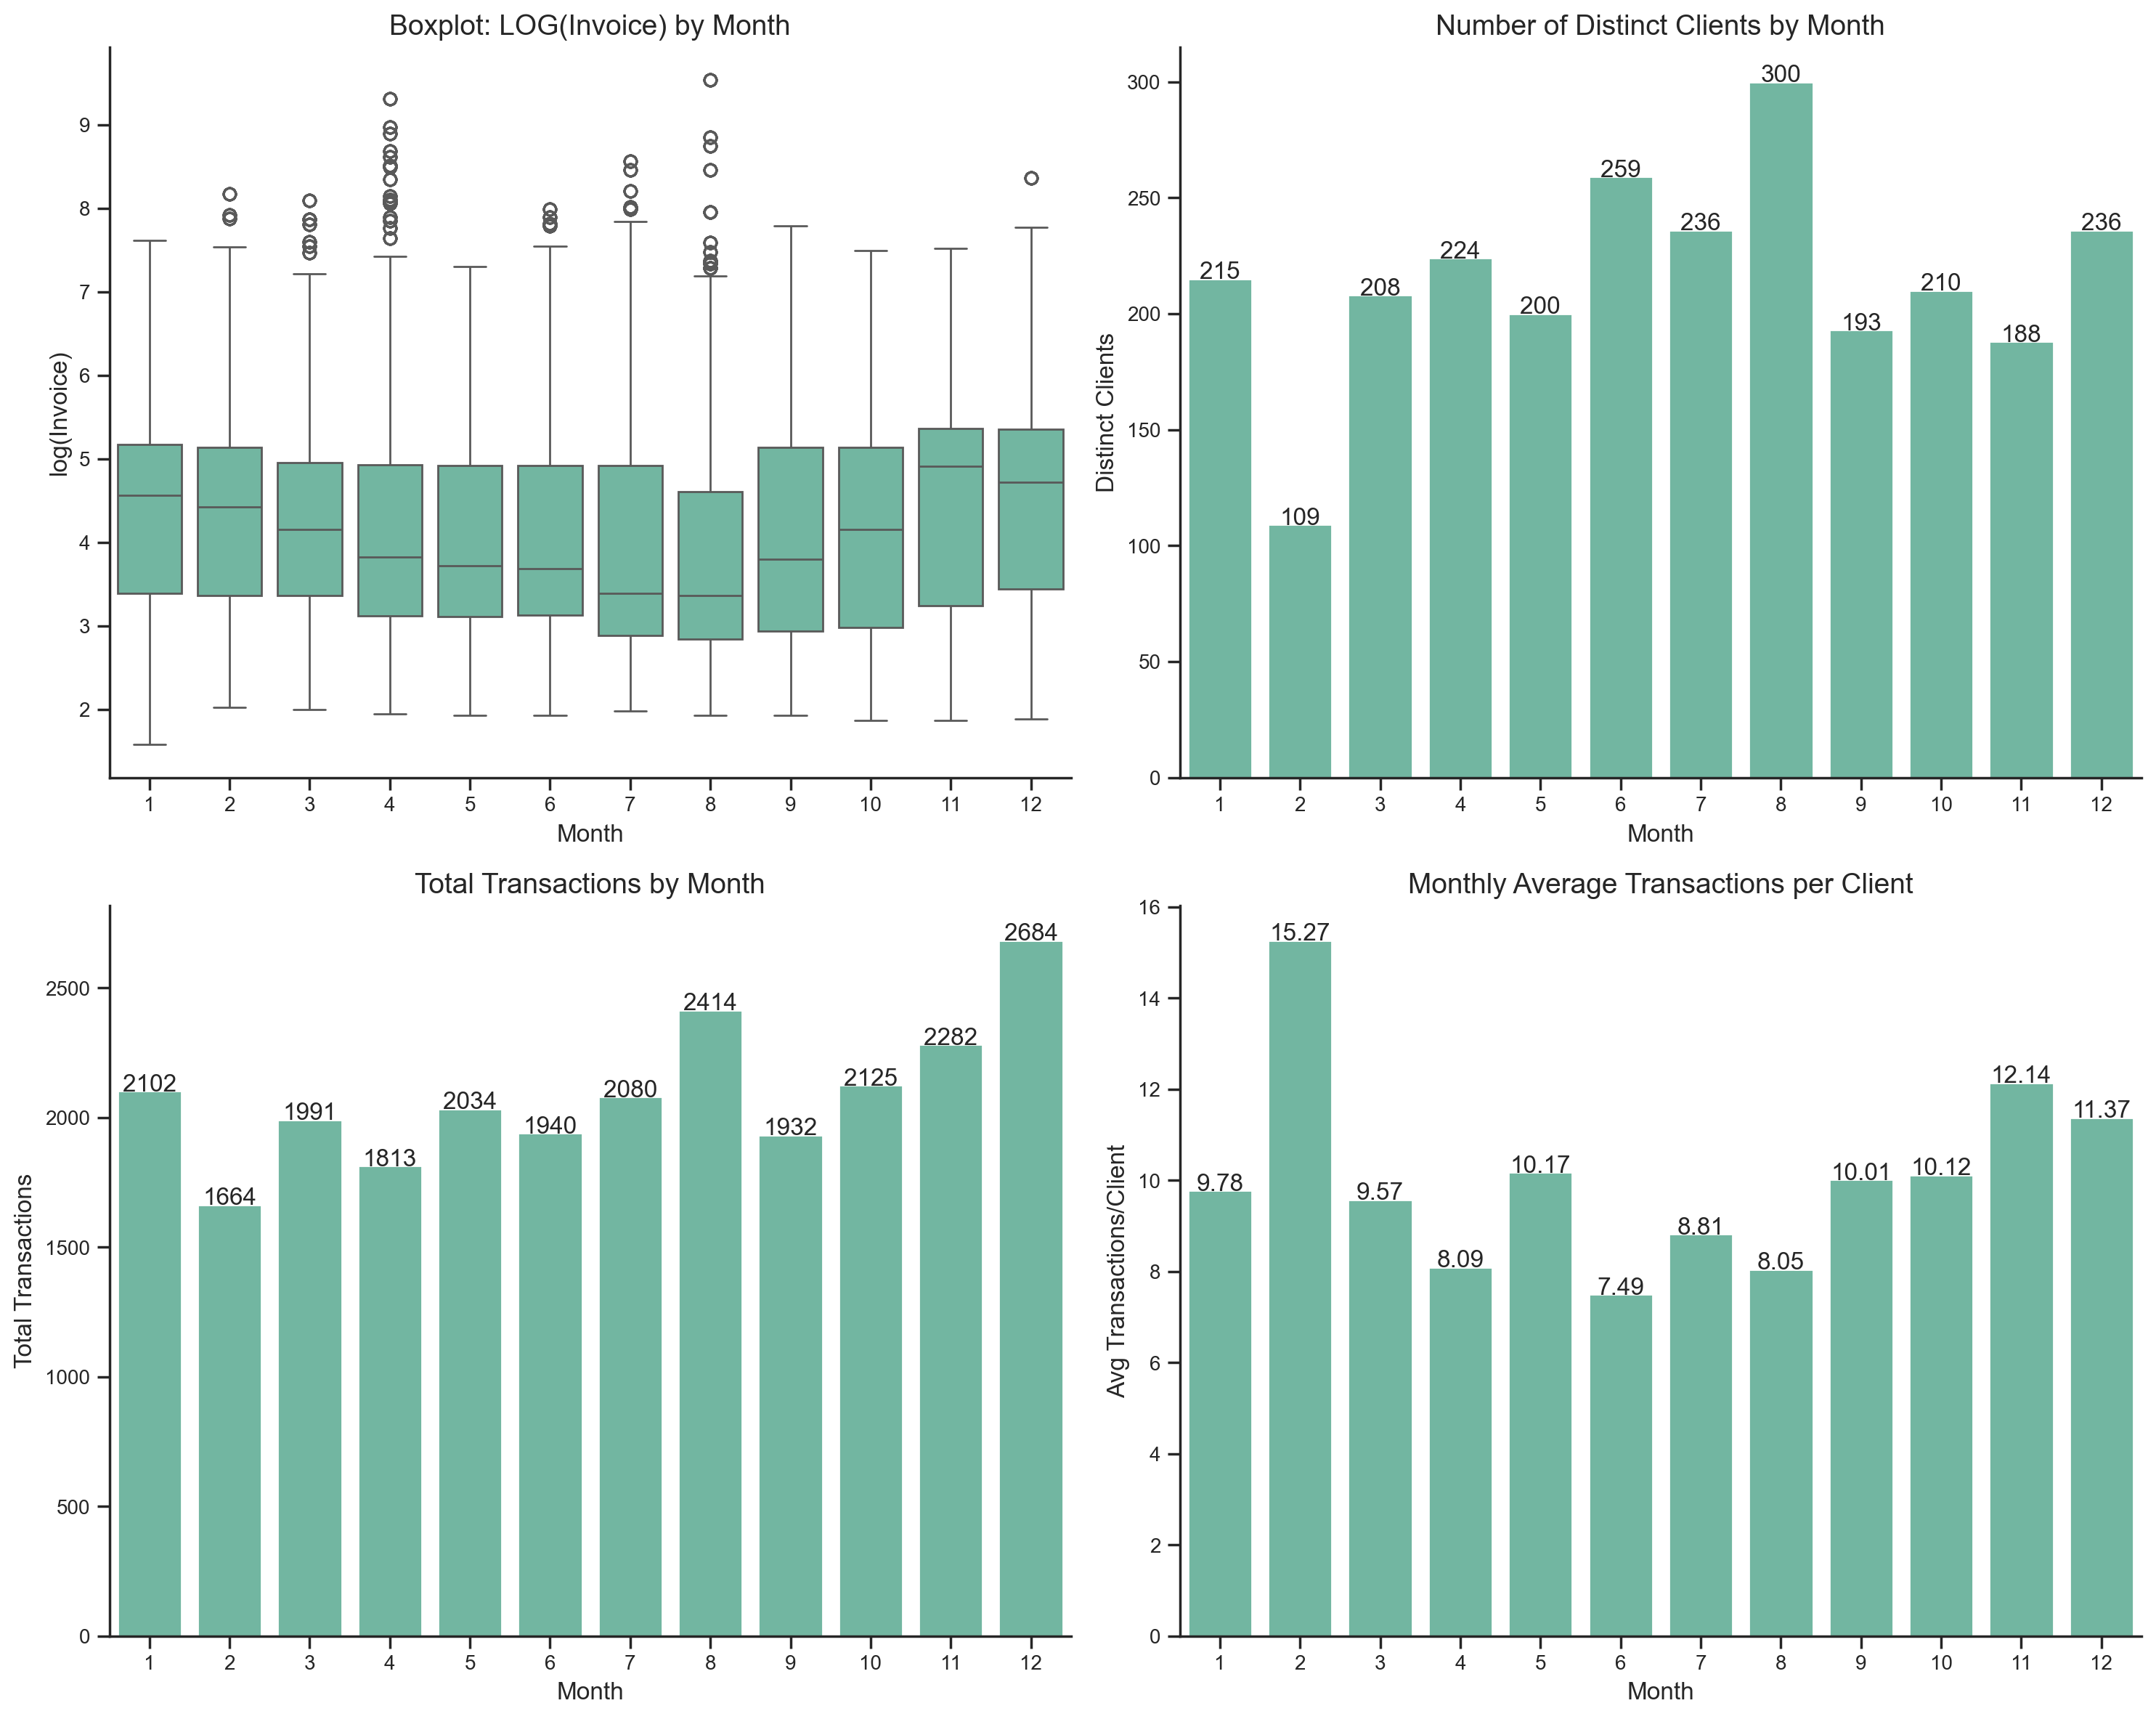

In [52]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Boxplot: Invoice by Month
g1 = sns.boxplot(x=data_tmp['month'], y=np.log(data_tmp['Invoice']), ax=axes[0, 0])
g1.set_title('Boxplot: LOG(Invoice) by Month')
g1.set_xlabel('Month')
g1.set_ylabel('log(Invoice)')

# Barplot: Number of Distinct Clients by Month
g2 = sns.barplot(x=monthly_metrics.index, y=monthly_metrics['distinct_clients'], ax=axes[0, 1])
g2.set_title('Number of Distinct Clients by Month')
g2.set_xlabel('Month')
g2.set_ylabel('Distinct Clients')
for index, value in enumerate(monthly_metrics['distinct_clients']):
    g2.text(index, value, f'{value:.0f}', ha='center')

# Barplot: Monthly Average Transactions per Client
g3 = sns.barplot(x=monthly_metrics.index, y=monthly_metrics['avg_trans_per_client'], ax=axes[1, 1])
g3.set_title('Monthly Average Transactions per Client')
g3.set_xlabel('Month')
g3.set_ylabel('Avg Transactions/Client')
for index, value in enumerate(monthly_metrics['avg_trans_per_client']):
    g3.text(index, value, f'{value:.2f}', ha='center')

# Barplot: Total Transactions by Month
g4 = sns.barplot(x=monthly_metrics.index, y=monthly_metrics['total_transactions'], ax=axes[1, 0])
g4.set_title('Total Transactions by Month')
g4.set_xlabel('Month')
g4.set_ylabel('Total Transactions')
for index, value in enumerate(monthly_metrics['total_transactions']):
    g4.text(index, value, f'{value:.0f}', ha='center')

plt.tight_layout()
plt.show()


### 2.2. Understand the retention of customers on month on month basis

To understand the retention of customers on a month-on-month basis, I will analyze the data to see how many customers from one monyh make repeat purchases in the following months.    
I'll create a matrix to show the number of customer retained from one month to the next and then calculate the retetion rate.

To calculate it, i will use the columns: `CustomerID` and `Transaction_Date`.

In [53]:
# Selecting the columns
retention_df = data_tmp[['CustomerID', 'Transaction_Date', 'month']]
retention_df['Transaction_Date'] = pd.to_datetime(retention_df['Transaction_Date']).dt.to_period('M')

# Removing the duplicated columns (if a client bought more than once, it is irrelevant for this analysis)
retention_df  = retention_df.drop_duplicates()

retention_df['first_purchase'] = retention_df.groupby('CustomerID')['Transaction_Date'].transform('max')

# Calculating the difference in months between the current transaction and the first purchase
retention_df['diff_months'] = abs(retention_df['first_purchase'].dt.month - retention_df['Transaction_Date'].dt.month)

retention_df

,CustomerID,Transaction_Date,month,first_purchase,diff_months
0,17850,2019-01,1,2019-01,0
153,13047,2019-01,1,2019-12,11
442,12583,2019-01,1,2019-08,7
782,13748,2019-01,1,2019-01,0
1105,15100,2019-01,1,2019-08,7
...,...,...,...,...,...
898467,14438,2019-12,12,2019-12,0
899130,12956,2019-12,12,2019-12,0
899453,15781,2019-12,12,2019-12,0
899538,14410,2019-12,12,2019-12,0


In [54]:
cohort_counts = retention_df.groupby(['Transaction_Date', 'diff_months', 'month'])['CustomerID'].nunique()

In [55]:
cohort_counts = retention_df.groupby(['Transaction_Date','diff_months','month'])['CustomerID'].nunique()
cohort_counts_df = cohort_counts.to_frame().rename(columns={'CustomerID':'users'}) \
                                .sort_values(by=['month'])

cohort_counts_df['retention_rate'] = cohort_counts_df['users'] / cohort_counts_df.groupby(["month"])["users"].transform("max")


cohorts_pivot = cohort_counts_df.pivot_table(index='Transaction_Date', columns = 'diff_months', values = 'retention_rate')


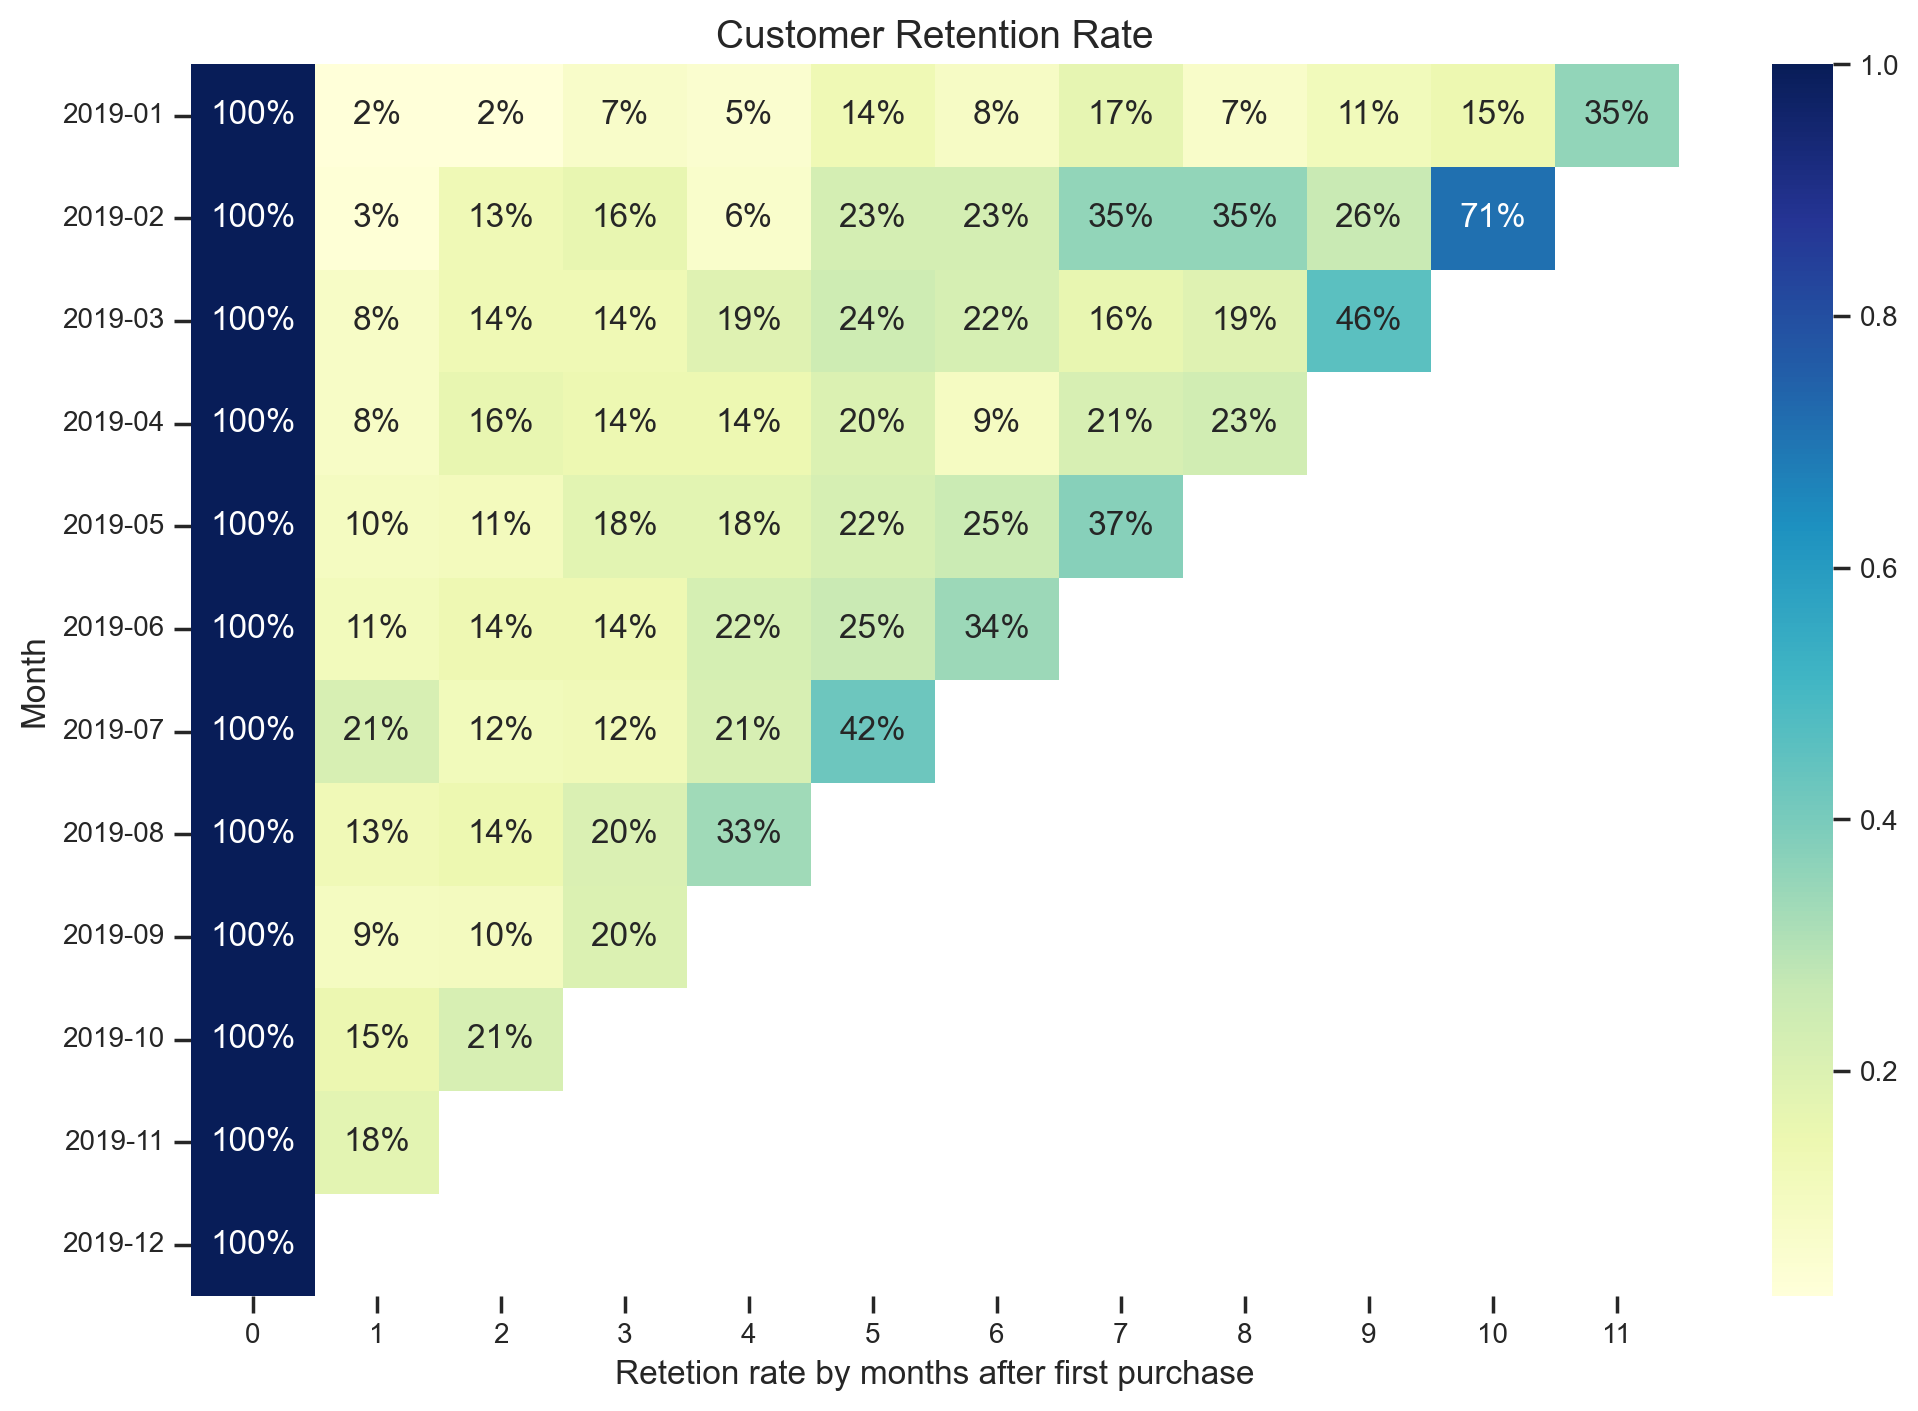

In [56]:

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
sns.heatmap(cohorts_pivot, annot=True, fmt=".0%", cmap="YlGnBu")
plt.title('Customer Retention Rate')
plt.ylabel('Month')
plt.xlabel('Retetion rate by months after first purchase')
plt.yticks(rotation=0)
plt.show()


### 2.3. How the revenues from existing/new customers on month on month basis

To analyze the revenues from existing and new customers on a month-on-month bases, I will follow these steps:
1. Identify wheter each transaction is from a new or existing customer.
2. Calculate the revenues for each month, segregating new and existing customers.
3. Aggregate the revenues on a month-by-month basis.


In [57]:
# Columns
retention_df = data_tmp[['CustomerID', 'Transaction_Date', 'month', 'Invoice']]

# Converting 'Transation_Date' to datetime and formatting it to year_month
retention_df['Transaction_Date'] = pd.to_datetime(retention_df['Transaction_Date']).dt.to_period('M')

# Aggruping the Invoive values per customer and per month
retention_df = retention_df.groupby(['CustomerID', 'Transaction_Date', 'month'])['Invoice'].agg('sum').reset_index(name='invoice_total')

# Removing duplicated
retention_df = retention_df.drop_duplicates()

# Adding a column with the first purchase for each customer
retention_df['first_purchase'] = retention_df.groupby('CustomerID')['Transaction_Date'].transform('min')

# Labeling the customers - new and existing
retention_df['customer_type'] = retention_df.apply(lambda row: 'New' if row['Transaction_Date'] == row['first_purchase'] else 'Existing', axis = 1)

# Calculating the revenues for each month and customer type
monthly_revenue = retention_df.groupby(['Transaction_Date', 'customer_type'])['invoice_total'].sum().reset_index()

# Pivoting the table to get the revenue matrix for new and existing customers
monthly_revenue_pivot = monthly_revenue.pivot_table(index='Transaction_Date', columns='customer_type', values='invoice_total', fill_value=0)
monthly_revenue_pivot['prop_new'] = monthly_revenue_pivot['New']/monthly_revenue_pivot.sum(axis=1) * 100

monthly_revenue_pivot

customer_type,Existing,New,prop_new
Transaction_Date,,,
2019-01,0.00,8918277.35,100.00
2019-02,915616.62,6294632.97,87.30
2019-03,1430587.64,7216418.66,83.46
2019-04,3543189.31,5118742.28,59.09
2019-05,2528358.80,4501492.77,64.03
2019-06,3120815.90,4505886.19,59.08
2019-07,4906950.28,3258474.87,39.91
2019-08,4845299.64,4437021.22,47.80
2019-09,5051477.16,3519699.64,41.06


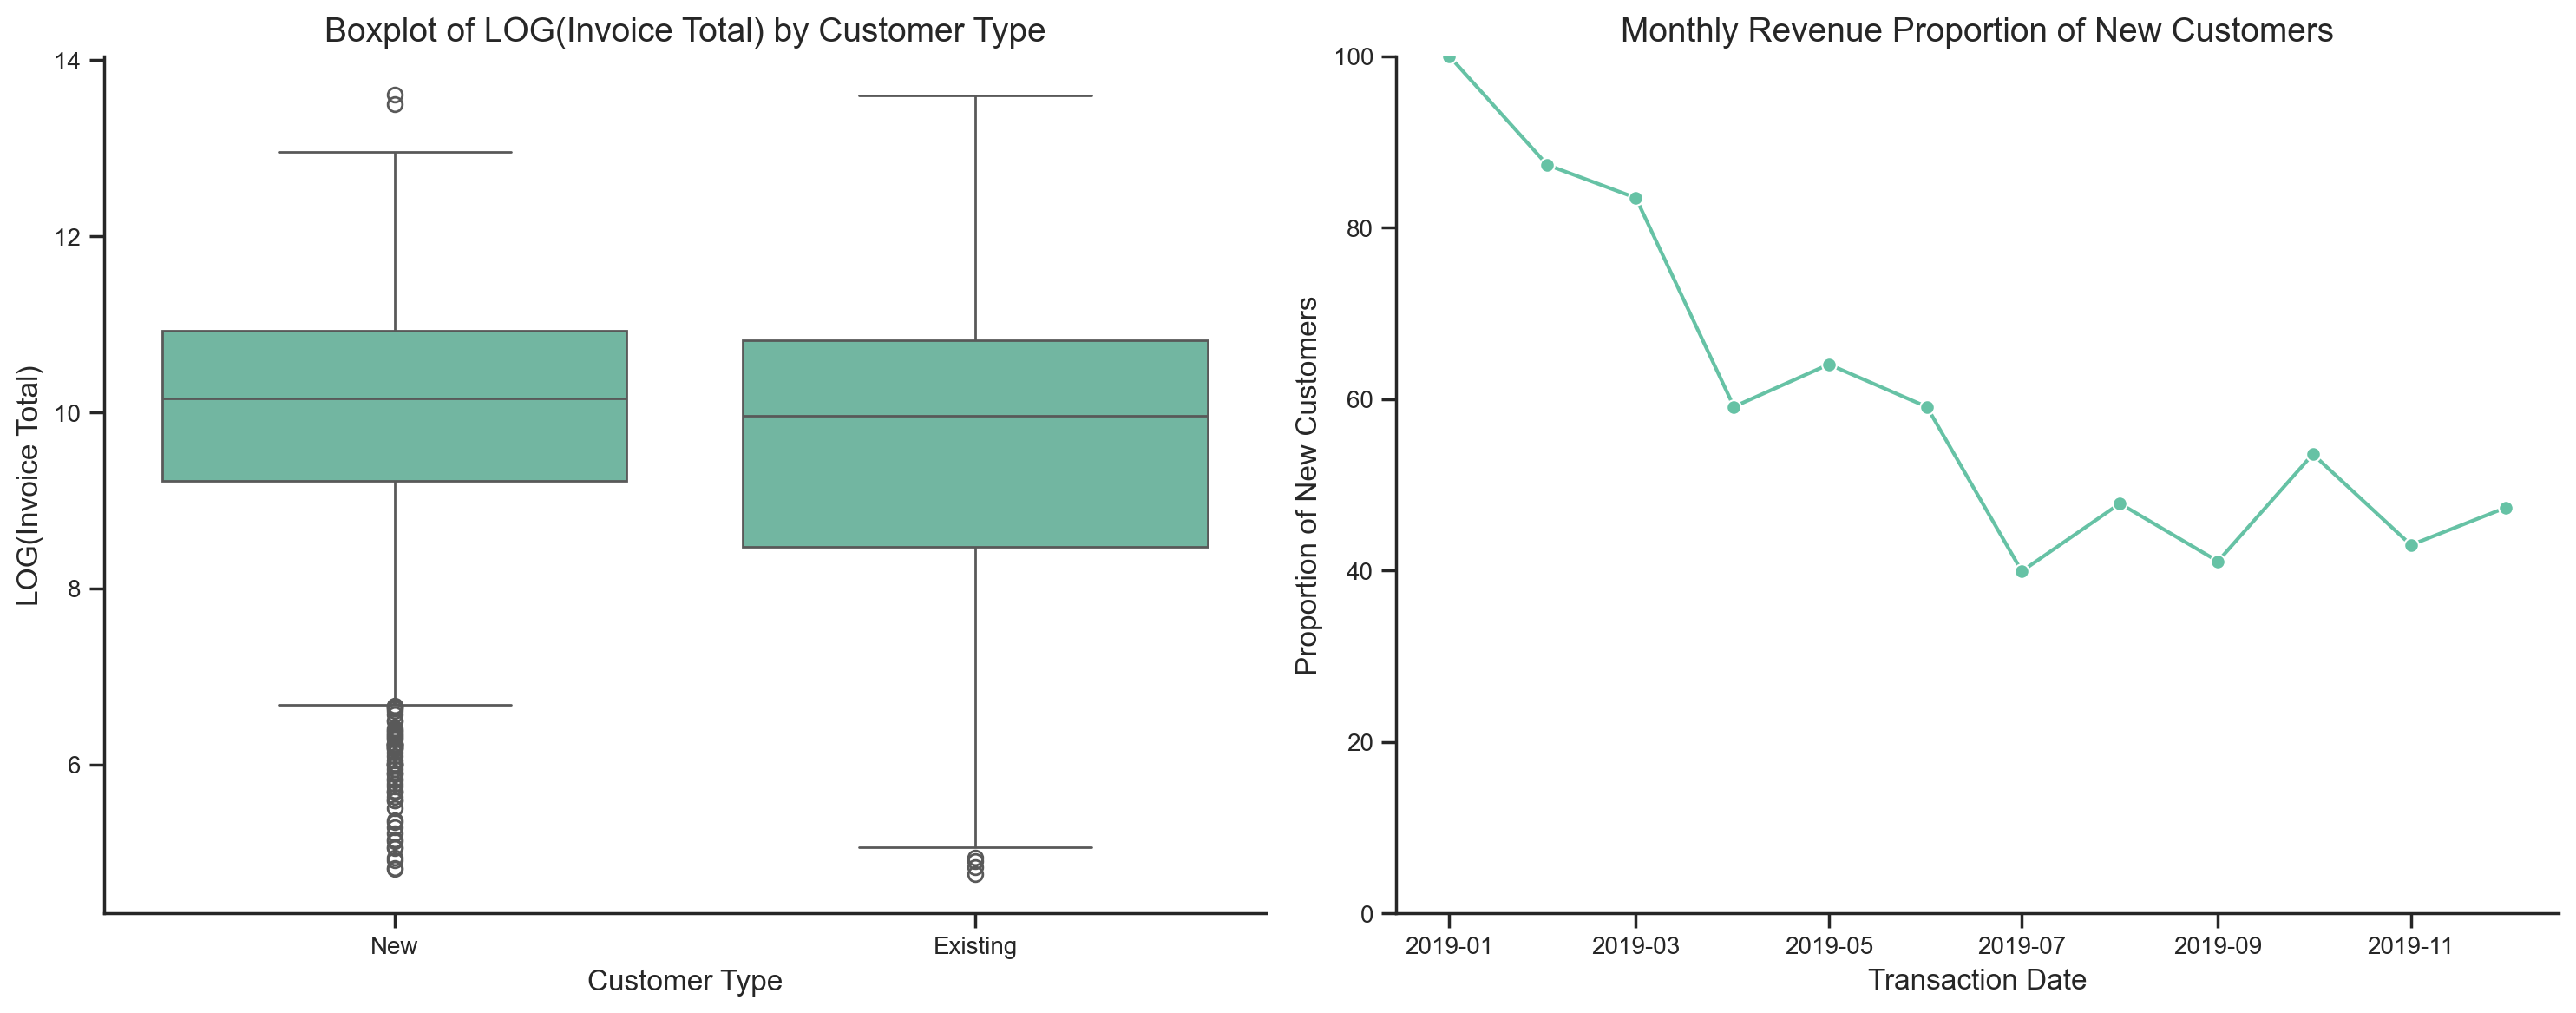

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

retention_df['log_invoice_total'] = np.log(retention_df['invoice_total'])


# Gráfico de caixa (Boxplot)
g1 = sns.boxplot(x='customer_type', y=('log_invoice_total'), data=retention_df, ax=axes[0])
g1.set_title('Boxplot of LOG(Invoice Total) by Customer Type')
g1.set_xlabel('Customer Type')
g1.set_ylabel('LOG(Invoice Total)')

teste = monthly_revenue_pivot.copy()
teset = teste.reset_index()

# Gráfico de linha (Line plot)
g2 = sns.lineplot(x=teste.index.to_timestamp(), y='prop_new', data=teste, ax=axes[1], marker='o')
g2.set_title('Monthly Revenue Proportion of New Customers')
g2.set_xlabel('Transaction Date')
g2.set_ylabel('Proportion of New Customers')
g2.set_ylim(0,100)

plt.tight_layout()
plt.show()

In [ ]:
# Testing if there is different between the values of new and existing invoices
grouped_describe = retention_df.groupby('customer_type')['invoice_total'].describe()
display(grouped_describe)
display(test_means_equality(retention_df, 'invoice_total', 'customer_type'))

,count,mean,std,min,25%,50%,75%,max
customer_type,,,,,,,,
Existing,1110.00,38499.38,57706.58,115.62,4780.04,21146.25,50150.66,803317.91
New,1468.00,42666.20,54701.13,122.78,10106.01,25810.62,55593.17,810657.05


{'p-value': 7.940492762386632e-06,
 'statistically_significant': True,
 'message': 'There is a statistically significant difference between the groups.'}

- According the test, there is a statistically significant difference between the news and the existing customers.
- Analysing the proportion of Invoice(News) comparing with the Invoice(Existent), the graph shows that the proportion tends to be half to half.

### 2.4. How the discounts playing role in the revenues?  

In [111]:
invoice_discounts = data_tmp[['Invoice', 'Discount_pct_ajus', 'month']]
invoice_discounts.groupby(['month','Discount_pct_ajus'])['Invoice'].describe()

count   mean    std  min   25%    50%    75%  \
month Discount_pct_ajus                                                   
1     0                 45560.00 128.12 139.81 4.86 29.05  96.15 175.58   
      10                23511.00 131.04 135.19 5.68 29.48 101.16 194.37   
2     0                 37162.00 124.09 169.74 7.59 27.49  81.33 170.40   
      20                18666.00 139.23 171.48 8.15 31.56  86.06 183.52   
3     0                 48790.00 105.34 155.95 7.37 26.55  58.40 137.40   
      30                25092.00 139.78 170.01 8.07 35.14  77.28 193.50   
4     0                 46240.00 119.61 348.18 7.09 22.18  45.57 136.90   
      10                24310.00 128.79 377.56 6.97 24.32  47.54 151.44   
5     0                 52360.00  86.41 120.72 6.87 21.74  38.86 136.13   
      20                25364.00  98.77 119.34 7.36 25.60  42.86 141.52   
6     0                 47158.00  95.15 138.36 6.87 21.95  38.08 136.90   
      30                24123.00 130.14 196.57 7.24 27.90  43.34 193.00   
7     0                 59398.00  89.85 184.86 7.31 17.33  29.03 136.90   
      10                29869.00  94.69 180.31 7.21 18.47  32.21 151.44   
8     0                 68969.00  81.38 178.01 6.87 16.76  26.74  95.68   
      20                35581.00 103.13 369.67 7.09 17.80  31.06 113.62   
9     0                 47566.00  99.77 140.63 6.87 17.33  39.03 136.90   
      30                25330.00 151.03 214.40 7.89 22.60  56.55 206.99   
10    0                 46818.00 120.50 148.32 6.44 18.97  60.15 169.90   
      10                23970.00 127.87 152.40 6.49 20.68  68.60 188.11   
11    0                 44149.00 146.80 158.55 6.44 24.42 110.45 181.12   
      20                23188.00 186.32 196.39 6.55 28.41 164.49 265.88   
12    0                 51170.00 137.62 151.70 6.56 27.66 112.46 173.57   
      30                25364.00 185.51 222.25 6.80 36.72 139.52 245.17   

                             max  
month Discount_pct_ajus           
1     0                  2032.98  
      10                 1277.18  
2     0                  3539.42  
      20                 2749.62  
3     0                  3272.26  
      30                 2464.08  
4     0                  7876.25  
      10                11084.00  
5     0                  1480.41  
      20                  919.52  
6     0                  2950.10  
      30                 2673.74  
7     0                  4727.85  
      10                 5252.50  
8     0                  6301.80  
      20                13803.51  
9     0                  1710.10  
      30                 2406.88  
10    0                  1798.29  
      10                 1408.39  
11    0                  1810.25  
      20                 1843.85  
12    0                  2377.32  
      30                 4269.42

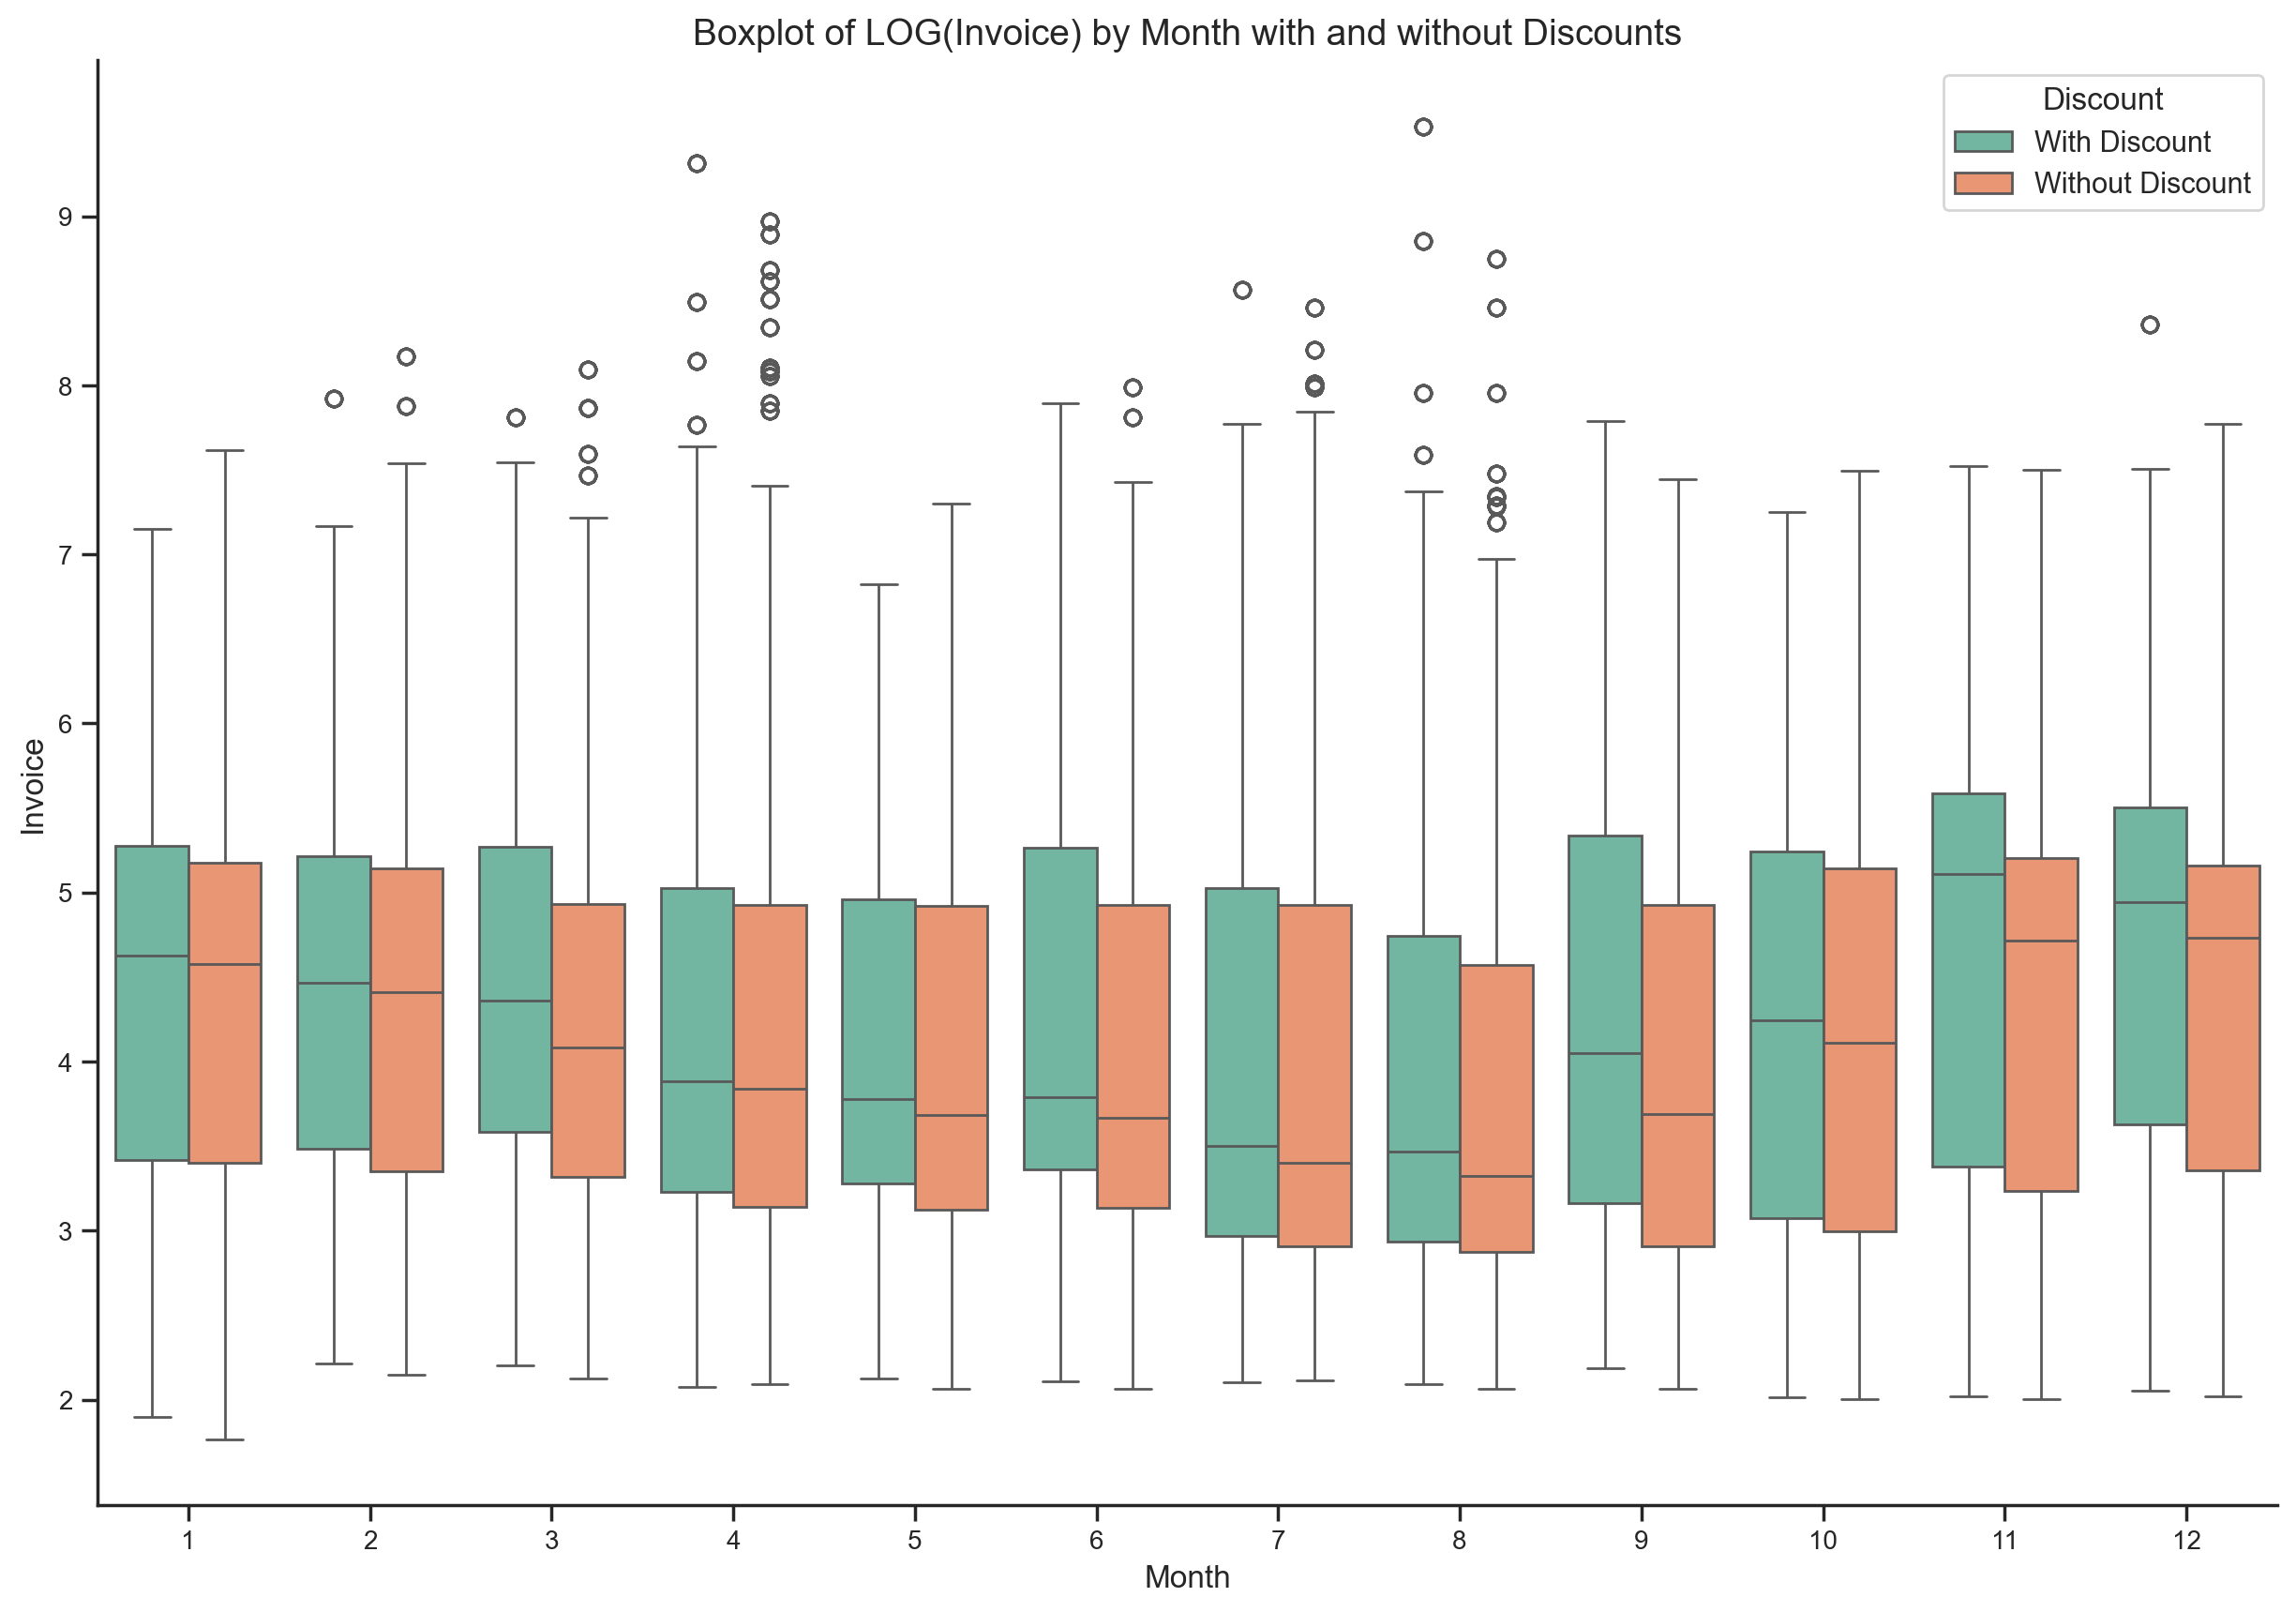

In [102]:
invoice_discounts['Discount'] = invoice_discounts['Discount_pct_ajus'].apply(lambda x: 'With Discount' if x > 0 else 'Without Discount')


invoice_discounts['Log_Invoice'] = np.log(invoice_discounts['Invoice'] + 1) 

# Criar o boxplot mês a mês
plt.figure(figsize=(15, 10))
sns.boxplot(x='month', y='Log_Invoice', hue='Discount', data=invoice_discounts)
plt.title('Boxplot of LOG(Invoice) by Month with and without Discounts')
plt.xlabel('Month')
plt.ylabel('Invoice')
plt.legend(title='Discount')
plt.show()

In [103]:
# Function to perform ANOVA for each month
def perform_test(month, df):
    discount_applied = df[(df['month'] == month) & (df['Discount_pct_ajus'] > 0)]['Invoice']
    no_discount = df[(df['month'] == month) & (df['Discount_pct_ajus'] == 0)]['Invoice']
    
    if len(discount_applied) > 0 and len(no_discount) > 0:
        # Normality test
        _, p_value_discount = stats.shapiro(discount_applied)
        _, p_value_no_discount = stats.shapiro(no_discount)
        
        if p_value_discount > 0.05 and p_value_no_discount > 0.05:
            # Se ambos os grupos forem normais, usar ANOVA
            f_stat, p_value = stats.f_oneway(discount_applied, no_discount)
            test_used = "ANOVA"
        else:
            # Se pelo menos um dos grupos não for normal, usar Mann-Whitney
            f_stat, p_value = stats.mannwhitneyu(discount_applied, no_discount)
            test_used = "Mann-Whitney"
        
        return test_used, f_stat, p_value
    else:
        return None, None, None

# Create a table with ANOVA results for each month
anova_results = []
for month in invoice_discounts['month'].unique():
    f_stat, p_value = perform_anova(month, invoice_discounts)
    if f_stat is not None and p_value is not None:
        anova_results.append({'Month': month, 'F-statistic': f_stat, 'P-value': p_value})

anova_df = pd.DataFrame(anova_results)

anova_df

,Month,F-statistic,P-value
0,1,6.90,0.01
1,2,98.10,0.00
2,3,759.49,0.00
3,4,10.44,0.00
4,5,180.44,0.00
5,6,758.91,0.00
6,7,13.82,0.00
7,8,164.62,0.00
8,9,1503.84,0.00
9,10,38.33,0.00


- The boxplot and the test of equality of means show that there are significant differences between invoices with discounts and those without discounts, including for each month.

### 2.5. Analyse KPI’s like Revenue, number of orders, average order value, number of  customers (existing/new), quantity, by category, by month, by week, by day etc…

For this question, I am assuming that it has been answered in the other questions and in the EDA analysis.

### 2.6. Understand the trends/seasonality of sales by category, location, month etc…  